In [2]:
# Cell 1: Import necessary libraries
import math  # For sin, exp, radians

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
# Cell 2: Table 2.1 - a and b coefficients for rain attenuation model
# Vertical polarization (v) - from table 2.1
coeff_v = {
    1.0: {'a': 0.0000308, 'b': .8592},
    1.5: {'a': 0.0000574, 'b': .8957},
    2.0: {'a': 0.0000998, 'b': .9490},
    2.5: {'a': 0.0001464, 'b': 1.0085},
    3.0: {'a': 0.0001942, 'b': 1.0688},
    3.5: {'a': 0.0002346, 'b': 1.1387},
    4.0: {'a': 0.0002461, 'b': 1.2476}
}

# Horizontal polarization (h) - from table 2.1
coeff_h = {
    1.0: {'a': 0.0000259, 'b': 0.9691},
    1.5: {'a': 0.0000443, 'b': 1.0185},
    2.0: {'a': 0.0000847, 'b': 1.0664},
    2.5: {'a': 0.0001321, 'b': 1.1209},
    3.0: {'a': 0.0001390, 'b': 1.2322},
    3.5: {'a': 0.0001155, 'b': 1.4189},
    4.0: {'a': 0.0001071, 'b': 1.6009}
}

print("Coefficient tables loaded:")
print("Vertical keys:", list(coeff_v.keys()))
print("Horizontal keys:", list(coeff_h.keys()))

Coefficient tables loaded:
Vertical keys: [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
Horizontal keys: [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]


In [4]:
# Cell 3: Interpolation fn for frequencies not in table 2.1

def interpolate_coeff(f, coeff_dict):
    """
    Linearly interpolate a and b coefficients for frequency f (GHz) 
    between nearest values 
    """

    frequencies = sorted(coeff_dict.keys()) #Sorts: [1,1.5,2,2.5,3,3.5,4
    
    if f < frequencies[0] or f > frequencies[-1]: #Checks if f is less than the first or greater than the last frequency then raises an error
        raise ValueError(f"Frequency {f} GHz is out of range")

    if f in coeff_dict: #If f is in the dictionary, return the exact a & b values
        return coeff_dict[f]['a'], coeff_dict[f]['b'] 

    # Find the two frequencies that are the closest to f.
    for i in range(len(frequencies) - 1): # minus 1 because we are comparing the current and next frequency. without it, we would be comparing the last frequency with itself
        if frequencies[i] <= f <= frequencies[i + 1]: # checks if f is between the current and next frequency
            low_f, high_f = frequencies[i], frequencies[i + 1] # sets the lower and higher frequencies
            low_a, low_b = coeff_dict[low_f]['a'], coeff_dict[low_f]['b'] # sets the lower a & b values
            high_a, high_b = coeff_dict[high_f]['a'], coeff_dict[high_f]['b'] # sets the higher a & b values    
            
            # Linear interpolation fraction
            frac = (f - low_f) / (high_f - low_f)
            
            # Interpolate a and b
            a = low_a + (high_a - low_a) * frac
            b = low_b + (high_b - low_b) * frac
            
            return a, b
    
    # Fallback (shouldn't reach here)
    return coeff_dict[f]['a'], coeff_dict[f]['b']

# Test the interpolation function
test_f = 2.25  # Between 2.0 and 2.5
a_v, b_v = interpolate_coeff(test_f, coeff_v)
print(f"Interpolated for f={test_f} GHz (vertical): a={a_v:.6f}, b={b_v:.4f}")

Interpolated for f=2.25 GHz (vertical): a=0.000123, b=0.9788


In [5]:
# Cell 4: locations dictionary from Table 2.5 - European city locations with latitude and altitude
locations = {
    'Madrid': {'phi': 40.4, 'hs_m': 588},
    'Tirana': {'phi': 41.3, 'hs_m': 104},
    'Rome': {'phi': 41.9, 'hs_m': 14},
    'Pristina': {'phi': 42.6, 'hs_m': 652},
    'Zagreb': {'phi': 45.8, 'hs_m': 130},
    'Vienna': {'phi': 48.2, 'hs_m': 193},
    'Paris': {'phi': 48.8, 'hs_m': 34},
    'Brussels': {'phi': 50.8, 'hs_m': 76},
    'London': {'phi': 51.5, 'hs_m': 14},
    'Berlin': {'phi': 52.5, 'hs_m': 34}
}

print("Locations loaded:")
for city, data in locations.items(): # for city (new variable) and data (new variable) in locations.items() (the items in the locations dictionary)
    print(f"{city}: φ={data['phi']}°, h_s={data['hs_m']} m") #print the city name, latitude, and altitude

Locations loaded:
Madrid: φ=40.4°, h_s=588 m
Tirana: φ=41.3°, h_s=104 m
Rome: φ=41.9°, h_s=14 m
Pristina: φ=42.6°, h_s=652 m
Zagreb: φ=45.8°, h_s=130 m
Vienna: φ=48.2°, h_s=193 m
Paris: φ=48.8°, h_s=34 m
Brussels: φ=50.8°, h_s=76 m
London: φ=51.5°, h_s=14 m
Berlin: φ=52.5°, h_s=34 m


In [6]:
# Cell 5: Core function to calculate rain attenuation (follows Figure 2.4 flowchart)
def calculate_rain_attenuation(f, pol, R, phi, hs_km, epsilon0):
    # Step 1: Get a and b using interpolation
    if pol == 'v':
        coeff_dict = coeff_v
    elif pol == 'h':
        coeff_dict = coeff_h
    else:
        raise ValueError("Polarization must be 'h' or 'v'")
    
    a, b = interpolate_coeff(f, coeff_dict)
    
    # Step 2: Calculate specific attenuation gamma
    gamma = a * (R ** b)
    
    # Step 3: Decision for h_r (effective rain height in km)
    if phi > 23:
        h_r = 5 - 0.073 * (phi - 23)
    else:
        h_r = 5
    
    # Step 4: Calculate slant path length l_r
    epsilon0_rad = math.radians(epsilon0)  # Convert degrees to radians
    if math.sin(epsilon0_rad) == 0:
        raise ValueError("Elevation angle cannot be 0 (division by zero)")
    l_r = (h_r - hs_km) / math.sin(epsilon0_rad)
    
    # Step 5: Calculate horizontal reduction factor s
    exp_term = math.exp(-0.015 * R)
    denominator = 35 * exp_term
    s = 1 / (1 + (l_r * math.sin(epsilon0_rad)) / denominator)
    
    # Step 6: Calculate total attenuation A_R
    A_R = gamma * s * l_r
    
    # Return results as dict (like Figure 2.5)
    return {
        'gamma': gamma,
        'h_r': h_r,
        'l_r': l_r,
        's': s,
        'A_R': A_R
    }

# Test with Vienna example from Figure 2.5 (f=2, pol='v', R=30, phi=48.2, hs_m=193, epsilon0=30)
hs_km = 193 / 1000  # Convert m to km
results = calculate_rain_attenuation(2, 'v', 30, 48.2, hs_km, 30)
print("Test results for Vienna:")
print(results)

Test results for Vienna:
{'gamma': 0.002517205152366363, 'h_r': 3.1604, 'l_r': 5.934800000000001, 's': 0.8826390294247574, 'A_R': 0.013185840790267767}


In [7]:
# Cell 6: Import for plotting (Matplotlib)
import matplotlib.pyplot as plt

print("Matplotlib imported successfully!")

Matplotlib imported successfully!


In [8]:
# Cell 7: Interactive user inputs and single location calculation (like Figure 2.5)
# Prompt for inputs with defaults from problems
f = float(input("Enter frequency f (GHz, default 2.5): ") or 2.5)
pol = input("Enter polarization ('h' or 'v', default 'v'): ") or 'v'
R = float(input("Enter rain rate R (mm/h, default 30): ") or 30)
epsilon0 = float(input("Enter elevation angle ε0 (degrees, default 15): ") or 15)
location = input("Enter location from Table 2.5 (e.g., 'Madrid', default 'Madrid'): ") or 'Madrid'

# Get phi and hs_km from locations dict
if location not in locations:
    raise ValueError(f"Invalid location: {location}. Available: {list(locations.keys())}")
phi = locations[location]['phi']
hs_m = locations[location]['hs_m']
hs_km = hs_m / 1000  # Convert to km

# Compute
results = calculate_rain_attenuation(f, pol, R, phi, hs_km, epsilon0)

# Display like Figure 2.5
print(f"\nResults for {location} (f={f} GHz, pol={pol}, R={R} mm/h, ε0={epsilon0}°):")
print(f"Specific Attenuation (γ): {results['gamma']:.5f} dB/km")
print(f"Reduction Factor (s): {results['s']:.4f}")
print(f"Attenuation (A_R): {results['A_R']:.4f} dB")


Results for Madrid (f=2.3 GHz, pol=v, R=25.0 mm/h, ε0=17.0°):
Specific Attenuation (γ): 0.00304 dB/km
Reduction Factor (s): 0.8845
Attenuation (A_R): 0.0289 dB


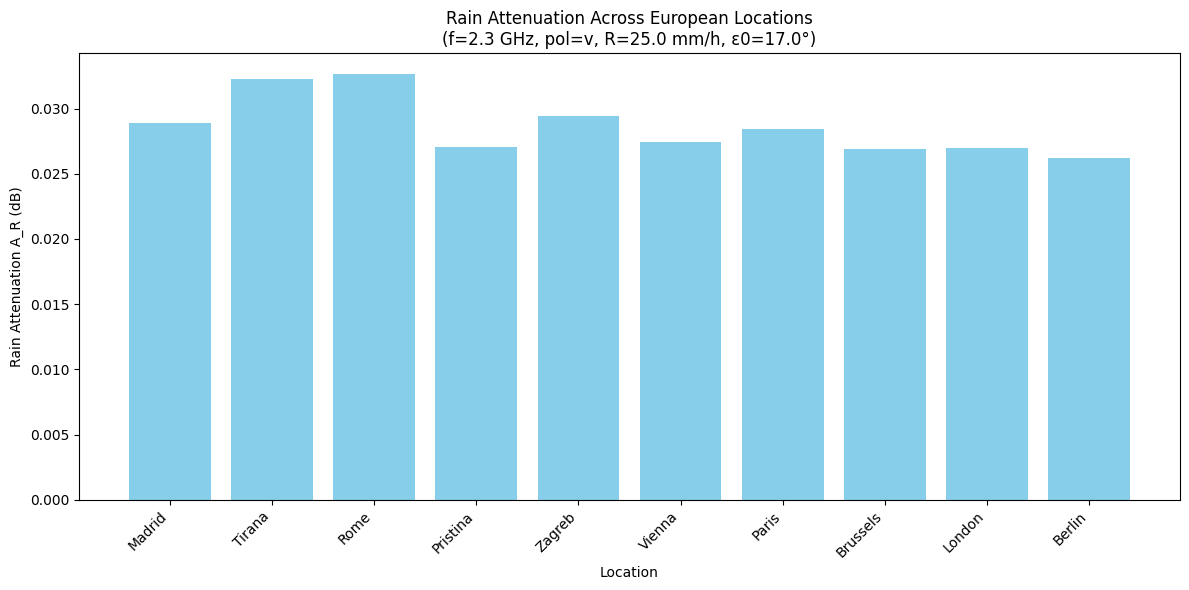

In [10]:
# Cell 8: Compute and graph A_R for all locations in Table 2.5 using user inputs from Cell 7
# Reuse f, pol, R, epsilon0 from previous cell (Jupyter state)

# Lists for plotting
cities = []
a_r_values = []

# Loop over locations
for city, data in locations.items():
    phi = data['phi']
    hs_km = data['hs_m'] / 1000
    results = calculate_rain_attenuation(f, pol, R, phi, hs_km, epsilon0)  # Note: uses user vars
    cities.append(city)
    a_r_values.append(results['A_R'])

# Plot bar graph
plt.figure(figsize=(12, 6))  # Size for readability
plt.bar(cities, a_r_values, color='skyblue')
plt.xlabel('Location')
plt.ylabel('Rain Attenuation A_R (dB)')
plt.title(f'Rain Attenuation Across European Locations\n(f={f} GHz, pol={pol}, R={R} mm/h, ε0={epsilon0}°)')
plt.xticks(rotation=45, ha='right')  # Rotate labels
plt.tight_layout()  # Fit nicely
plt.show()